# Data Augmentation - Experimento

Data Augmentation é uma estratégia bastante utilizada para impulsionar treinamento de modelos. Se baseando em diversas transformações nos dados, as abordagens de Data Augmentation conseguem multiplicar os seus dados mantendo os mesmos rótulos. Exemplos dessas transformações em dados de imagens são rotações, translações, mudança de coloração, e etc.

A implementação desse componente foi feita utilizando a biblioteca [torchvision](https://pytorch.org/vision/stable/index.html).

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

Para esse componente, a base de dados deve estar no seguinte formado:
- Arquivo CSV chamado dataset.csv contendo as colunas "image_path" e "subset", entre outras, caso necessário. Onde:
    - image_path: caminho para o arquivo de imagem.
    - subset: conjunto ao qual a amostra faz parte, pode ser "train", "test", e "val". 
- Imagens coloridas (3 canais)
- Cada conjunto de treino, validação e teste possuem sua pasta com suas respectivas imagens. Um exemplo da árvore de diretórios pode ser observado abaixo:

```bash
dataset
|________dataset.csv
|________train
|        |__________image0.jpg
|        |__________image1.jpg
|        |__________image2.jpg
|        |__________image3.jpg
|               ...
|
|________val
|        |__________image4.jpg
|        |__________image5.jpg
|        |__________image6.jpg
|        |__________image7.jpg
|               ...
|
|________test
|        |__________image8.jpg
|        |__________image9.jpg
|        |__________image10.jpg
|        |__________image11.jpg
|              ...
```

In [4]:
dataset = "/tmp/data/yolo-2.zip" #@param {type:"string"}
image_path = "image_path" #@param {type:"string", label:"Caminho das imagens", description:"Coluna da tabela com o caminho para as imagens."}
augmentation_rate = 5 #@param {type: "number", label:"Quantidade de aumentação dos dados", description: "Inteiro positivo que informa o número de vezes que cada transformação será feita nas imagens"}
horizontal_flip = True #@param {type: "boolean", label:"Espelhamento Horizontal", description: "Aplica espelhamentos horizontais aleatoriamente nas imagens do conjunto de dados"}
vertical_flip = True #@param {type: "boolean", label:"Espelhamento Vertical", description: "Aplica espelhamentos verticais aleatoriamente nas imagens do conjunto de dados"}
crop = True #@param {type: "boolean", label: "Recorte Aleatório", description: "Aplica Recortes aleatórios nas imagens para gerar novas imagens para o conjunto de dados."} 
color_jitter = True #@param {type: "boolean", label:"Mudanças de coloração", description:"Aplica aleatoriamente mudanças de brilho, contraste, saturação e HUE das imagens do conjunto de dados."}
perspective = True #@param {type: "boolean", label:"Mudança de perspectiva", description: "Aplica transformações aleatoriamente para mudança de perspectiva nas imagens do conjunto de dados."}
rotate = True #@param {type: "boolean", label:"Rotaciona a imagem", description: "Aplica rotações aleatoriamente nas imagens do conjunto de dados.."}

In [5]:
# data augmentation parameters

data_augmentation_parameters = {
    'augmentation_rate': augmentation_rate,
    'horizontal_flip': horizontal_flip,
    'vertical_flip': vertical_flip,
    'crop': crop,
    'color_jitter': color_jitter,
    'perspective': perspective,
    'rotate': rotate
}

if augmentation_rate < 1:
    augmentation_rate = 1

## Leitura do conjunto de dados


In [6]:
# Construct dataset folder name for unzipped files
folder = '.'.join(dataset.split('.')[:-1])

# Creating empty folder
!mkdir -p {folder}

# Extracting files
!unzip -o {dataset} -d {folder}

Archive:  /tmp/data/yolo-2.zip
   creating: /tmp/data/yolo-2/test/
  inflating: /tmp/data/yolo-2/test/sunflower.png  
   creating: /tmp/data/yolo-2/train/
   creating: /tmp/data/yolo-2/val/
 extracting: /tmp/data/yolo-2/dataset.csv  
  inflating: /tmp/data/yolo-2/df_squad_test_bert_chuncked.csv  


In [7]:
import pandas as pd

# Read images path dataset
df = pd.read_csv(folder + '/dataset.csv')
df[image_path] = folder + df[image_path]

# Get all images paths for predicting
X = df[image_path].values

In [13]:
from PIL import Image

images = [ Image.open(img_path) for img_path in X ]

width, height = images[0].size
print(f"image width: {width}, image height: {height}")
print(images)
    

image width: 244, image height: 244
[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=244x244 at 0x7F19D31F7C40>]


In [43]:
import torchvision.transforms as T

#augmentation_rate = 1
crop_size = (int(width * 0.8),int(height * 0.8))

jitter = T.ColorJitter(brightness=.5, hue=.3)
perspective_transformer = T.RandomPerspective(distortion_scale=0.6, p=1.0)
rotater = T.RandomRotation(degrees=(0, 180))
crop_transform = T.RandomCrop(crop_size)
hflip = T.RandomHorizontalFlip()
vflip = T.RandomVerticalFlip() 

transformed_dataset = []
for img in images:
    transformed_images = []
    if horizontal_flip:
        transformed_images += [hflip(img) for _ in range(augmentation_rate) ]
    if vertical_flip:
        transformed_images += [vflip(img) for _ in range(augmentation_rate) ]
    if crop:
        transformed_images += [ crop_transform(img) for _ in range(augmentation_rate) ]
    if color_jitter:
        transformed_images += [ jitter(img) for _ in range(augmentation_rate) ]
    if perspective:
        transformed_images += [ perspective_transformer(img) for _ in range(augmentation_rate) ]
    if rotate:
        transformed_images += [ rotater(img) for _ in range(augmentation_rate) ]
    
    transformed_dataset.append(transformed_images)
    
transformed_dataset = dict(zip(X, transformed_dataset))

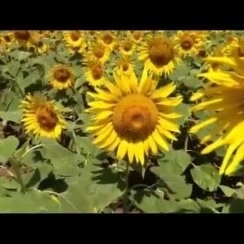

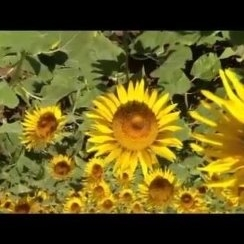

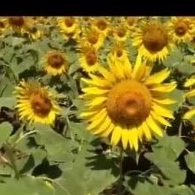

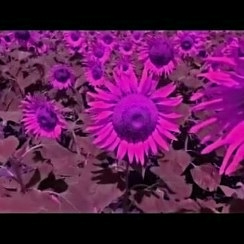

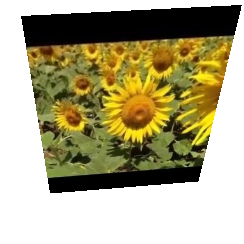

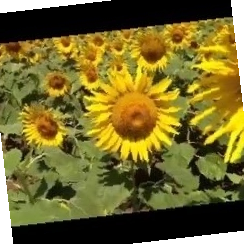

In [47]:
# all transformations for image X[0]
for transf_img in transformed_dataset[X[0]]:
    transf_img.show()

## Conteúdo da tarefa

## Salva resultados da tarefa

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.<br>
Use essa pasta para salvar modelos, metadados e outros resultados.

In [51]:
from joblib import dump

artifacts = {
    "data_augmentation_parameters": data_augmentation_parameters
}

for original_path, transf_images in transformed_dataset.items():
    
    for idx, img in enumerate(transf_images):
        img.save(original_path.split(".")[0] + f"_transformed_img_{idx}.png")
        #img.save(original_path + f"{_transformed_img_{idx}.png")

dump(artifacts, "/tmp/data/data_augmentation.joblib")

In [ ]:
# compress augmented dataset into a zip file
!zip {dataset.split(".")[0] + "augmented.zip"} -r {dataset.split(".")[0] + "/"}